In [59]:
import os
import glob
import re
import pandas as pd
import shutil
import zipfile
import geopandas as gpd

In [16]:
# recopy tdm, centers, datasets to inputs
replace_inputs = True

In [95]:
# variables

# location of tdm for model runs
tdm_path = r'E:\GitHub\WF-TDM-v9x'

# transit files
input_model_line_files_folder = 'input/transit-lin-files'
tdm_model = 'WF-TDM-v9x_application/v901-transit-corridors_6adb48'
tdm_transit_scenario = 'Lin_2032_3Corridors'

# network shapefile
tdm_link_shapefile = 'WFv902_MasterNet - Link.shp'
input_tdm_link_shapefile_folder = 'input/tdm-link-shapefile'

# taz shapefile
taz_shapefile = 'WFv900_TAZ.shp'
input_taz_shapefile_folder = 'input/taz-shapefile'

# se data
se_years = ['2032','2042','2050']

# Projects

df_projects = pd.DataFrame([
    [1,'West Weber Rail'                , 'WestWeber'    ],
    [2,'3300/3500 South'                , 'BRT3533S_Core'],
    [3,'Roy to Clearfield via 3500 West', 'ClearRoyWest' ]
], columns=['project_id','project_name','tdm_line_name'])

df_projects['tdm_model'] = tdm_model  # add field for joining later

display(df_projects)


df_centers = pd.DataFrame(data = {
    'Parameter':           ['FAR', 'bldg size', 'size of hh units', 'sf per employee', 'units per acre', 'sf per acre', '% residential', '% non res', 'gross to net conversion (streets, etc)', 'final units per acre', 'final emps per acre', 'application area', 'application area miles'],
    'Neighborhood Center': [0.6  , 26136      , 1000              , 500              , 26.136          , 52.27        , 0.85           , 0.15       , 0.8                                     , 18                    , 6                    , '1/8 mile radius' , 0.125                   ],
    'City Center':         [1.13 , 49222.8    , 850               , 450              , 57.90917647     , 109.38       , 0.85           , 0.15       , 0.8                                     , 39                    , 13                   , '990 foot radius' , 0.1875                  ],
    'Urban Center':        [1.5  , 65340      , 750               , 400              , 87.12           , 163.35       , 0.85           , 0.15       , 0.8                                     , 59                    , 20                   , '1/4 mile radius' , 0.25                    ]
})
df_centers.set_index('Parameter', inplace=True)
df_centers = df_centers.T.reset_index()
df_centers.rename(columns={'index':'center type'}, inplace=True)
display(df_centers)

,project_id,project_name,tdm_line_name,tdm_model
0,1,West Weber Rail,WestWeber,WF-TDM-v9x_application/v901-transit-corridors_...
1,2,3300/3500 South,BRT3533S_Core,WF-TDM-v9x_application/v901-transit-corridors_...
2,3,Roy to Clearfield via 3500 West,ClearRoyWest,WF-TDM-v9x_application/v901-transit-corridors_...


Parameter,center type,FAR,bldg size,size of hh units,sf per employee,units per acre,sf per acre,% residential,% non res,"gross to net conversion (streets, etc)",final units per acre,final emps per acre,application area,application area miles
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25


In [67]:
# copy over inputs

if replace_inputs:

    # copy over tdm link shapefile 
    
    extensions = [".shp", ".shx", ".dbf", ".prj"]  # list all possible extensions

    for ext in extensions:
        src_file = os.path.join(os.path.join(tdm_path, '1_Inputs/3_Highway/GIS'), os.path.splitext(tdm_link_shapefile)[0] + ext)
        dest_file = os.path.join(input_tdm_link_shapefile_folder, os.path.splitext(tdm_link_shapefile)[0] + ext)
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)
            print(f"Copied {src_file} to {dest_file}")
        else:
            print(f"{src_file} does not exist")

    # copy over tdm taz shapefile 
    
    extensions = [".shp", ".shx", ".dbf", ".prj"]  # list all possible extensions

    for ext in extensions:
        src_file = os.path.join(os.path.join(tdm_path, '1_Inputs/1_TAZ'), os.path.splitext(taz_shapefile)[0] + ext)
        dest_file = os.path.join(input_taz_shapefile_folder, os.path.splitext(taz_shapefile)[0] + ext)
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)
            print(f"Copied {src_file} to {dest_file}")
        else:
            print(f"{src_file} does not exist")

    # copy over parsed LIN files

    files = ["files.csv", "lines.csv", "links.csv", "nodes.csv", "speeds-tf-delay.csv"]  # list all possible extensions

    for file in files:
        src_file = os.path.join(os.path.join(tdm_path, '1_Inputs/4_Transit/_Transit Processing Tools/Parse-Transit-Lin-Files/output'), file)
        dest_file = os.path.join(input_model_line_files_folder, file)
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)
            print(f"Copied {src_file} to {dest_file}")
        else:
            print(f"{src_file} does not exist")

    # copy wasatch choice feature class

    import requests
    import json

    # Define the REST endpoint URL for the feature layer
    rest_endpoint = "https://services1.arcgis.com/taguadKoI1XFwivx/arcgis/rest/services/Wasatch_Choice_2050_Centers_(Vision_Map)/FeatureServer/0/query"

    # Parameters for the API request
    params = {
        "where": "1=1",  # Query all records
        "outFields": "*",  # Get all fields
        "f": "geojson"  # Format of the output
    }

    # Send GET request to the REST endpoint
    response = requests.get(rest_endpoint, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response content as GeoJSON
        geojson_data = response.json()
        
        # Save the GeoJSON data to a file
        geojson_path = "input/wasatch-choice-centers/wc-centers.geojson"
        with open(geojson_path, "w") as file:
            json.dump(geojson_data, file)
        
        print(f"Feature layer downloaded and saved as {geojson_path}")
    else:
        print(f"Failed to download the dataset. HTTP status code: {response.status_code}")

    # copy over SE files

    files = ["files.csv", "lines.csv", "links.csv", "nodes.csv", "speeds-tf-delay.csv"]  # list all possible extensions

    for file in files:
        src_file = os.path.join(os.path.join(tdm_path, '1_Inputs/4_Transit/_Transit Processing Tools/Parse-Transit-Lin-Files/output'), file)
        dest_file = os.path.join(input_model_line_files_folder, file)
        if os.path.exists(src_file):
            shutil.copy(src_file, dest_file)
            print(f"Copied {src_file} to {dest_file}")
        else:
            print(f"{src_file} does not exist")
else:
    print('Input files not updated')

Copied E:\GitHub\WF-TDM-v9x\1_Inputs/3_Highway/GIS\WFv902_MasterNet - Link.shp to input/tdm-link-shapefile\WFv902_MasterNet - Link.shp
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/3_Highway/GIS\WFv902_MasterNet - Link.shx to input/tdm-link-shapefile\WFv902_MasterNet - Link.shx
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/3_Highway/GIS\WFv902_MasterNet - Link.dbf to input/tdm-link-shapefile\WFv902_MasterNet - Link.dbf
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/3_Highway/GIS\WFv902_MasterNet - Link.prj to input/tdm-link-shapefile\WFv902_MasterNet - Link.prj
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/1_TAZ\WFv900_TAZ.shp to input/taz-shapefile\WFv900_TAZ.shp
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/1_TAZ\WFv900_TAZ.shx to input/taz-shapefile\WFv900_TAZ.shx
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/1_TAZ\WFv900_TAZ.dbf to input/taz-shapefile\WFv900_TAZ.dbf
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/1_TAZ\WFv900_TAZ.prj to input/taz-shapefile\WFv900_TAZ.prj
Copied E:\GitHub\WF-TDM-v9x\1_Inputs/4_Transit/_Transit Processing Tools/Par

In [43]:
# Get transit line link data for projects

_df_transit_lin_files_files = pd.read_csv(os.path.join(input_model_line_files_folder, 'files.csv'))
_df_transit_lin_files_lines = pd.read_csv(os.path.join(input_model_line_files_folder, 'lines.csv'))
_df_transit_lin_files_links = pd.read_csv(os.path.join(input_model_line_files_folder, 'links.csv'))

_df_transit_lin_files_files_lines = pd.merge(_df_transit_lin_files_files, _df_transit_lin_files_lines, on=['file_index'])
_df_transit_lin_files_files_lines_links = pd.merge(_df_transit_lin_files_files_lines, _df_transit_lin_files_links, on=['file_index','name'])

df_project_transit_links = pd.merge(_df_transit_lin_files_files_lines_links, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_links = df_project_transit_links[['project_id','link_id']]
df_project_transit_links

,project_id,link_id
0,2,25430_25534
1,2,25534_25640
2,2,25640_25685
3,2,25685_25669
4,2,25669_25602
...,...,...
2179,1,15184_15183
2180,1,15183_15182
2181,1,15182_15181
2182,1,15181_15180


In [35]:
# Read the shapefile
gdf_tdm_link = gpd.read_file(os.path.join(input_tdm_link_shapefile_folder, tdm_link_shapefile))


In [61]:
gdf_tdm_link.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

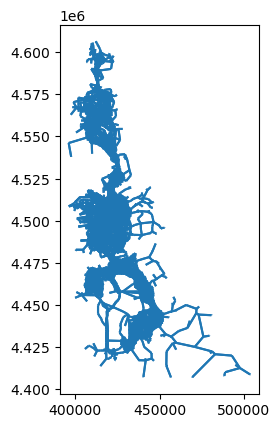

In [36]:
# display the gdf
gdf_tdm_link.plot()

In [44]:
# recalc link id because since it's not populated completely with changes.
gdf_tdm_link['LINKID'] = gdf_tdm_link['A'].astype(str) + '_' + gdf_tdm_link['B'].astype(str)

In [81]:
gdf_tdm_link = gdf_tdm_link[['A','B','LINKID','geometry']]
gdf_tdm_link

,A,B,LINKID,geometry
0,1,29685,1_29685,"LINESTRING (411935.000 4605642.000, 412478.126..."
1,2,29685,2_29685,"LINESTRING (412641.000 4606013.000, 412478.126..."
2,3,29645,3_29645,"LINESTRING (408993.000 4603544.000, 409632.415..."
3,4,29671,4_29671,"LINESTRING (410051.000 4604806.000, 409642.112..."
4,5,29680,5_29680,"LINESTRING (413394.000 4603600.000, 413482.000..."
...,...,...,...,...
57130,95064,95025,95064_95025,"LINESTRING (473181.550 4444171.200, 471782.100..."
57131,95064,95026,95064_95026,"LINESTRING (473181.550 4444171.200, 480751.220..."
57132,95064,95056,95064_95056,"LINESTRING (473181.550 4444171.200, 476015.900..."
57133,95065,3621,95065_3621,"LINESTRING (480730.710 4444037.000, 480767.876..."


,A,B,LINKID,geometry,project_id,link_id
0,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
1,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
2,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
3,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
4,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
...,...,...,...,...,...,...
2137,28166,28117,28166_28117,"LINESTRING (412738.974 4560442.481, 412102.000...",3,28166_28117
2138,28166,28117,28166_28117,"LINESTRING (412738.974 4560442.481, 412102.000...",3,28166_28117
2139,28166,28117,28166_28117,"LINESTRING (412738.974 4560442.481, 412102.000...",3,28166_28117
2140,28166,28117,28166_28117,"LINESTRING (412738.974 4560442.481, 412102.000...",3,28166_28117


<AxesSubplot:>

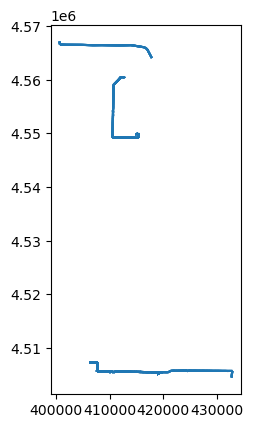

In [86]:
gdf_tdm_link_with_projects = pd.merge(gdf_tdm_link, df_project_transit_links, left_on='LINKID', right_on='link_id')
display(gdf_tdm_link_with_projects)
gdf_tdm_link_with_projects.plot()

In [103]:
df_centers

Parameter,center type,FAR,bldg size,size of hh units,sf per employee,units per acre,sf per acre,% residential,% non res,"gross to net conversion (streets, etc)",final units per acre,final emps per acre,application area,application area miles
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25


Neighborhood Center
City Center
Urban Center


,project_id,center type,buffered
0,1,Neighborhood Center,"POLYGON ((400466.162 4567044.057, 400463.284 4..."
1,2,Neighborhood Center,"POLYGON ((406237.717 4507061.634, 406199.520 4..."
2,3,Neighborhood Center,"POLYGON ((410381.622 4549202.137, 410381.572 4..."
0,1,City Center,"POLYGON ((400367.493 4567024.528, 400363.176 4..."
1,2,City Center,"POLYGON ((406237.537 4506961.051, 406199.520 4..."
2,3,City Center,"POLYGON ((410281.077 4549203.068, 410281.003 4..."
0,1,Urban Center,"POLYGON ((400268.823 4567005.000, 400263.067 4..."
1,2,Urban Center,"POLYGON ((406237.357 4506860.467, 406199.520 4..."
2,3,Urban Center,"POLYGON ((410180.532 4549203.999, 410180.433 4..."


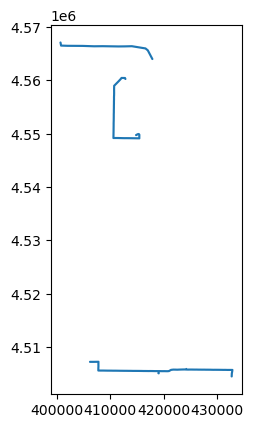

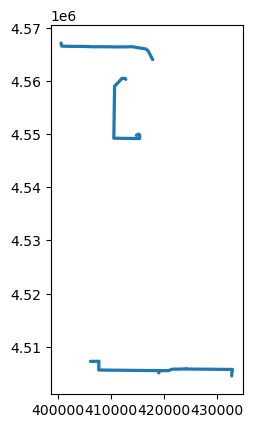

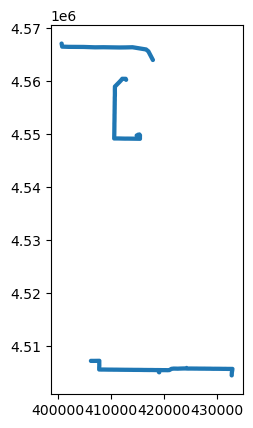

In [119]:
gdf_buffered_projects_by_center_type = gpd.GeoDataFrame()

for index, row in df_centers.iterrows():
    print(row['center type'])

    # Merging lines based on 'project_id'
    _gdf_tdm_link_with_projects_merged = gdf_tdm_link_with_projects.dissolve(by='project_id')
    _gdf_tdm_link_with_projects_merged['center type'] = row['center type']

    # Buffer the merged lines by 'application area miles'
    # Convert miles to an appropriate unit if your CRS is not in miles
    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
    _gdf_tdm_link_with_projects_merged['buffered'] = _gdf_tdm_link_with_projects_merged.geometry.buffer(row['application area miles'] * 1609.34)

    # If you want the buffered geometry as the main geometry
    _gdf_tdm_link_with_projects_merged.set_geometry('buffered', inplace=True)

    _gdf_tdm_link_with_projects_merged.drop(columns=['geometry','A','B','LINKID','link_id'], inplace=True)
    _gdf_tdm_link_with_projects_merged.reset_index(inplace=True)

    _gdf_tdm_link_with_projects_merged.plot()

    gdf_buffered_projects_by_center_type = pd.concat([gdf_buffered_projects_by_center_type,_gdf_tdm_link_with_projects_merged])

display(gdf_buffered_projects_by_center_type)

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry
0,9,Adobe Rock Products,Industrial District,Tooele Valley RPO,2.182418e+06,7173.333596,"POLYGON ((390801.962 4498399.620, 391047.762 4..."
1,10,Airport Employment Area,Employment District,Tooele Valley RPO,6.985133e+06,11891.917566,"POLYGON ((386070.571 4498673.920, 387277.082 4..."
2,27,BYU,Educational Center,Utah County,2.878946e+06,8602.109367,"POLYGON ((445289.047 4456709.083, 445293.007 4..."
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4..."
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4..."
...,...,...,...,...,...,...,...
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4..."
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4..."
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4..."
300,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,"POLYGON ((424116.214 4503855.048, 424035.251 4..."


<AxesSubplot:>

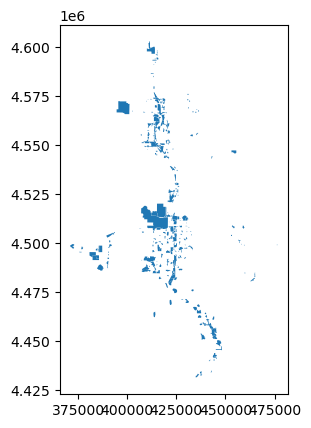

In [88]:
# read in wasatch choice center dataset and convert to UTM Zone 12N
gdf_wc_centers = gpd.read_file('input/wasatch-choice-centers/wc-centers.geojson')
gdf_wc_centers = gdf_wc_centers.to_crs(26912)
display(gdf_wc_centers)
display(gdf_wc_centers.plot())

<AxesSubplot:>

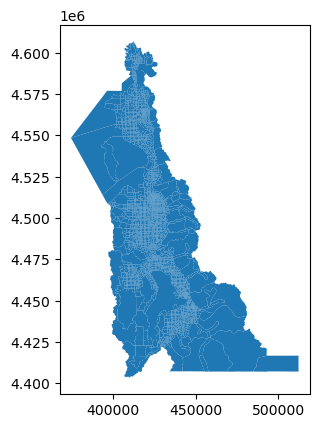

In [68]:
# import taz shapefile
gdf_taz = gpd.read_file(os.path.join(input_taz_shapefile_folder, taz_shapefile))
gdf_taz = gdf_taz.to_crs(26912)
gdf_taz.plot()

,AreaName,AreaType,TAZID,ACRES,geometry,area_sqm,area_acres
0,BYU,Educational Center,2936,92.039493,"POLYGON ((443983.827 4456371.423, 443984.107 4...",2905.835292,0.718048
1,Downtown Provo,Urban Center,2936,92.039493,"POLYGON ((443984.107 4456391.213, 443983.827 4...",2454.016472,0.606401
2,Hillcrest,City Center,2936,92.039493,"POLYGON ((443973.947 4456391.703, 443882.168 4...",102814.265319,25.405958
3,BYU,Educational Center,2940,77.742947,"POLYGON ((444202.107 4456362.513, 443993.117 4...",172895.256776,42.723348
4,Downtown Provo,Urban Center,2940,77.742947,"POLYGON ((444202.192 4456351.871, 443992.473 4...",2685.678688,0.663646
...,...,...,...,...,...,...,...
1627,St. Marks Hospital,Employment District,1523,84.599218,"POLYGON ((427061.950 4504386.720, 427061.877 4...",53472.551344,13.213355
1628,St. Marks Hospital,Employment District,1524,85.065629,"POLYGON ((427360.509 4504647.546, 427592.014 4...",85258.103571,21.067736
1629,St. Marks Hospital,Employment District,1525,106.486114,"POLYGON ((427840.722 4504451.103, 428034.794 4...",13938.412439,3.444257
1630,St. Marks Hospital,Employment District,1544,72.279784,"POLYGON ((427259.021 4504284.708, 427259.196 4...",7825.885098,1.933818


<AxesSubplot:>

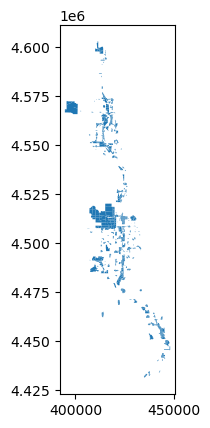

In [127]:
# Assuming gdf1, gdf2, and gdf3 are your GeoDataFrames

# Perform the intersection of the first two GeoDataFrames
gdf_wc_centers_tax = gpd.overlay(gdf_wc_centers[['AreaName','AreaType','geometry']], gdf_taz[['TAZID','ACRES','geometry']], how='intersection')


# Calculate the area in square meters
gdf_wc_centers_tax['area_sqm'] = gdf_wc_centers_tax.geometry.area

# Convert the area to acres
gdf_wc_centers_tax['area_acres'] = gdf_wc_centers_tax['area_sqm'] / 4046.85642

# The final_intersection GeoDataFrame now contains the intersection of all three GeoDataFrames
display(gdf_wc_centers_tax)
gdf_wc_centers_tax.plot()
